# Дано:
Младшему исследователю из Вашего отдела дали выполнить задание по дизайну признаков (фич) в новом проекте.
Определите слабые стороны этого решения и попробуйте улучшить результат (RMSE).

Задача была сформулирована так: придумать такие дискретные фичи (не более 5 фичей, каждая фича имеет не более 5 значений), чтобы максимально точно предсказывать по ним значения c3, c4, c5 из имеющегося датасета.

Помимо новых дискретных фич допускается использование c1, c2 и d1 в качестве входных переменных (X).

In [160]:
!pip install catboost

In [161]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

In [162]:
df = pd.read_csv('test_data.csv', header=0, index_col=0)

In [163]:
df.head()

,c1,c2,c3,c4,c5,d1
0,1702.339676,97.151127,1187.449039,1090.136386,1106.530204,0.0
1,1667.720643,80.366907,1081.197827,945.367799,1087.782255,1.0
2,1719.730118,69.581754,967.808030,812.721484,995.881811,0.0
3,1681.895917,96.473315,1146.784418,1047.934966,1112.788168,0.0
4,1880.594545,90.238614,1056.165331,909.991794,1021.066083,0.0


Удаляем пропуски.

In [164]:
print(df.isnull().values.any())
df.dropna(inplace=True)
df.isnull().values.any()

True


False

Не до конца разобрался почему есть признак который вычисляется из таргета, но так как задача учебная оставил.

In [165]:
def get_discrete_feature1(df):
    if pd.isna(df['c3']) or pd.isna(df['c5']) or pd.isna(df['c4']):
        return None

    c5 = df['c5']
    c3 = df['c3']
    c4 = df['c4']

    if c3 - c5 >= 92 and c3 - c4 < 230:
        return 'cl1'

    if c5 - c3 < 92 and c3 - c5 < 92 and c3 - c4 < 230 and c5 - c4 < 250:
        return 'cl2'

    if c3 - c5 <= 25 and c5 - c3 < 92 and c3 - c4 >= 230:
        return 'cl3'

    if c5 - c3 >= 92 and c5 - c4 < 230:
        return 'cl4'

    else:
        return 'cl5'

In [166]:
# add categorial features
for ind in df.index:
    row = df.loc[ind]
    df.loc[ind, 'd2'] = get_discrete_feature1(row)
df.dropna(inplace=True)
df.reindex()

,c1,c2,c3,c4,c5,d1,d2
0,1702.339676,97.151127,1187.449039,1090.136386,1106.530204,0.0,cl2
1,1667.720643,80.366907,1081.197827,945.367799,1087.782255,1.0,cl2
2,1719.730118,69.581754,967.808030,812.721484,995.881811,0.0,cl2
3,1681.895917,96.473315,1146.784418,1047.934966,1112.788168,0.0,cl2
4,1880.594545,90.238614,1056.165331,909.991794,1021.066083,0.0,cl2
...,...,...,...,...,...,...,...
772,1630.241487,59.990761,847.202994,823.506819,990.289583,1.0,cl4
773,1693.725223,88.109343,1076.182680,955.658598,1208.467438,1.0,cl5
774,1911.658458,84.421679,1014.765775,915.530432,1044.422575,0.0,cl2
775,1951.382558,75.296976,963.907047,873.414881,992.615990,0.0,cl2


Нормализуем вещественные признаки и таргет.
* Для подсчёта rmse трансформируем их обратно к исходному масштабу.
* На нормализованных признаках в данном случае лучше анализировать дендрограмму, а затем кластеризовать.


In [167]:
# add scaling features
scaler_features = preprocessing.StandardScaler()
scaler_target = preprocessing.StandardScaler()

scaler_features.fit(df[['c1', 'c2']])
scaler_target.fit(df[['c3', 'c4', 'c5']])

df[['c1', 'c2']] = scaler_features.transform(df[['c1', 'c2']])
df[['c3', 'c4', 'c5']] = scaler_target.transform(df[['c3', 'c4', 'c5']])

Строим дендрограмму чтобы подобрать гипер параметр (кол-во кластеров) для метода k-means.

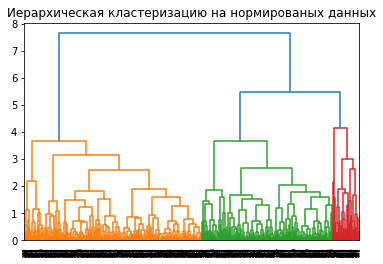

In [168]:
# Реализация иерархической кластеризации при помощи функции linkage
mergings = linkage(df[['c1', 'c2', 'd1']], method='complete')
clt = dendrogram(mergings)

plt.title(f"Иерархическая кластеризацию на нормированых данных")
plt.show()

Хорошо просматриваются 3 кластера.

In [169]:
kmeans3 = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df[['c1', 'c2', 'd1']])
df['km'] = kmeans3.predict(df[['c1', 'c2', 'd1']])

Категоризируем вещественные признаки. Заменяем число номером квантиля в который оно попадает.

In [170]:
df['q_c1'] = pd.qcut(df.c1, 4, labels=False)
df['q_c2'] = pd.qcut(df.c2, 4, labels=False)

Читерские признаки (вычисляемые от таргета).  
~~без этих признаков rmse 46.80016186889012~~

In [171]:
df['q_c3'] = pd.qcut(df.c3, 4, labels=False)
df['q_c4'] = pd.qcut(df.c4, 4, labels=False)
df['q_c5'] = pd.qcut(df.c5, 4, labels=False)

Признак d1 сильно напоминает метку класса. Он имеет только значения 0 и 1. Сделаем признак категориальным.

In [172]:
df['d1_'] = df.d1.map(lambda x: '0' if x == 0.0 else '1')

In [173]:
df.head()

,c1,c2,c3,c4,c5,d1,d2,km,q_c1,q_c2,q_c3,q_c4,q_c5,d1_
0,-0.062965,1.243956,1.702379,1.826887,0.742522,0.0,cl2,0,1,3,3,3,3,0
1,-0.396958,0.318833,0.810379,0.742014,0.558037,1.0,cl2,2,1,2,3,3,3,1
2,0.104813,-0.275630,-0.141550,-0.252016,-0.346288,0.0,cl2,2,2,1,1,1,1,0
3,-0.260200,1.206596,1.360992,1.510636,0.804102,0.0,cl2,0,1,3,3,3,3,0
4,1.656781,0.862948,0.600227,0.476912,-0.098468,0.0,cl2,0,3,3,3,2,2,0


Об учимся с читерскими признаками, если потребуется можно обучиться без них. Для это нужно раскомментировать строку.

In [174]:
# с читерскими признаками 
x_features = ['c1', 'c2', 'd1_', 'km', 'd2', 'q_c1', 'q_c2', 'q_c3', 'q_c4', 'q_c5']
# без читерских признаков получаем ровно 2 вещественных и 5 категориальных признаков (как и требуется в задание)
# x_features = ['c1', 'c2', 'd1_', 'km', 'd2', 'q_c1', 'q_c2']  # раскомментировать 
y_features = ['c3', 'c4', 'c5']

In [175]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [176]:
model = CatBoostRegressor(silent=True, loss_function='MultiRMSE').fit(train_df[x_features], train_df[y_features], cat_features=[2, 3, 4, 5, 6])

In [177]:
def rmse(a1, a2):
    diff = (a1 - a2)
    return float(np.mean(np.sqrt(np.mean(diff ** 2, axis=0))))

У нас нормированные признаки поэтому используем `inverse_transform` для честного подсчёта ошибки.

In [178]:
pred = np.array(model.predict(test_df[x_features]))

print(rmse(scaler_target.inverse_transform(pred), scaler_target.inverse_transform(test_df[y_features])))

35.553616169364055
